<a href="https://colab.research.google.com/github/nagamamo/financial_data_science/blob/main/8_2_hull_white_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

8.2　ハル=ホワイト・モデルによるイールドカーブの導出

　本例では、QuantLib 1.29を用いて、ハル=ホワイト・モデルを用いて金利の期間構造を算出する手順を紹介します。まず初めにQuantLib 1.29をインストールします。

In [ ]:
pip install QuantLib

　続いて、インストールしたQuantLibからライブラリをインポートします。加えて、数値演算のnumpyと図表作成のためのmatplotlibのライブラリを読み込みます。

In [2]:
#[1]ライブラリの読み込み
import QuantLib as ql #QuantLibライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt

　続いてハル＝ホワイト・モデルの各初期値を設定します。初期値の設定が必要とされるのは、短期金利の平均回帰（収束）速度a、金利ボラティリティsigma、一年間の日数、最長償還期間、フォワードレート初期値、今日の日付です。

In [20]:
#[2]初期値の定義
a = 0.05 #金利の平均回帰速度
sigma = 0.15 #金利ボラティリティ
days_a_year = 360 #一年間の日数
maturity = 30 #イールドカーブの最長償還期間
forward_rate =0.47 #フォワードレート初期値
num_days=ql.Thirty360(ql.Thirty360.BondBasis) #QuantLib日数の定義
today = ql.Date(29,6,2025) #今日の日付

　[2]において設定した初期値を用いて、[3]において、まず一様分布からイールドカーブ初期値を導出します。そして[4]ではこの初期イールドカーブをインプットすることでガウス分布に基づく乱数を発生させます。

In [21]:
#[3]イールドカーブ導出の前処理
ql.Settings.instance().evaluationDate=today #試算実施日の設定
initial_curve=ql.FlatForward(today,ql.QuoteHandle(ql.SimpleQuote(forward_rate)),num_days) #一様分布での初期設定
initial_curve_handle=ql.YieldTermStructureHandle(initial_curve) #初期期間構造の導出

　続いて、モンテカルロ法により、[4]で生成したガウス分布にしたがう乱数を用いて、短期金利からイールドカーブ算出を複数回実施するモデルを定義します。

In [22]:
#[4]モデルの定式化
hull_white=ql.HullWhiteProcess(initial_curve_handle,a,sigma) #初期期間構造をHW過程へ変換
gauss_random=ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(days_a_year,ql.UniformRandomGenerator())) #一様分布からガウス分布の乱数生成
gauss_path=ql.GaussianPathGenerator(hull_white,maturity,days_a_year,gauss_random,False) #HW過程に基づく金利算出シミュレーションの定式化

　モンテカルロ法による演算回数を設定し、瞬間短期金利から複数回のイールドカーブ算出を行います。この演算と同時に、ハル=ホワイト・モデルの理論値も併せて算出します。この理論値は、ロンドン・インペリアル・カレッジのダミアノ・ブリゴ教授とブルームバーグ社グローバル数理分析室総責任者ファビアノ・メルキュリオ博士が2006年の著書で示したモデルを[5]6行目で定義することにより算出します。

In [23]:
#[5]ハル=ホワイト・モデルに基づくパスの発生
def generate_paths(num_paths,days_a_year):
  arr=np.zeros((num_paths,days_a_year+1))
  for i in range(num_paths):
    model_path=gauss_path.next()
    path=model_path.value()
    time=[path.time(j) for j in range(len(path))]
    value=[path[j] for j in range(len(path))]
    arr[i,:]=np.array(value)
  return np.array(time),arr

　最後に、演算結果と理論値を可視化します。

Text(0, 0.5, 'Yield(%)')

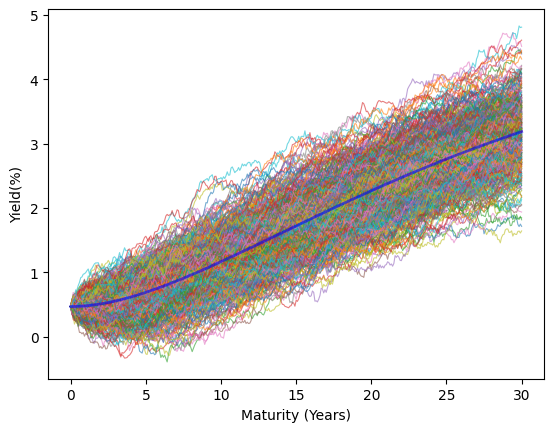

In [24]:
#[6]シミュレーション結果と理論値の可視化
num_paths =500 #繰り返し演算回数の設定
time, paths = generate_paths(num_paths,days_a_year) #演算回数とデータ頻度の設定
for i in range(num_paths):
  plt.plot(time,paths[i,:],lw=0.8,alpha=0.6)#シミュレーション結果の可視化
def alpha(forward,sigma, a,t):#理論値算出の定式化
  return forward + 0.5*np.power(sigma/a*(1.0-np.exp(-a*t)),2)#理論モデルの定義
plt.plot(time,alpha(forward_rate,sigma,a,time),"b-",lw=2,alpha=0.6)#理論値の可視化
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield(%)")

In [25]:
import pandas as pd
df=pd.DataFrame({'Maturity (Years)':time,'Yield (%)':alpha(forward_rate,sigma,a,time)})
df = df.set_index("Maturity (Years)")
df

,Yield (%)
Maturity (Years),
0.000000,0.470000
0.083333,0.470078
0.166667,0.470310
0.250000,0.470694
0.333333,0.471229
...,...
29.666667,3.159714
29.750000,3.166282
29.833333,3.172831
